<a href="https://colab.research.google.com/github/11abdellah11/Segmentation_iogs/blob/main/SUIM_IOGS_ATSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet segmentation sémantique - IOGS/ATIS - Dataset SUIM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importation of libraries
import cv2
from glob import glob
from tqdm.notebook import tqdm
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np

import torchvision
import torch.nn.functional as F

# Paramètres

In [ ]:
# define the batch size and input size for the input data
batch_size = 4
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
path = '/content/drive/MyDrive/ML_project_segm/train_val'
image_size = 576

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

# Define the dataset and data loaders
class SUIM(torch.utils.data.Dataset):
    def __init__(self, datapath, transform, image_size):
        self.datapath = datapath
        self.img_paths = glob(self.datapath + "/images/*.jpg")
        self.transform = transform
        self.size = image_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
      img_path = self.img_paths[idx]
      mask_path = self.datapath + "/masks/" + img_path.split('/')[-1][:-3] + 'bmp'
      image = cv2.imread(img_path)
      dataset_mask = cv2.imread(mask_path)
      transformed = self.transform(image=image, mask=dataset_mask)
      mask = self.gen_mask(transformed['mask'])
      return transformed['image'] * 1.0, mask

    def gen_mask(self, dataset_mask):

      dataset_mask = T.functional.center_crop(dataset_mask.permute(2, 1, 0), (576, 576))
      mod_mask = (dataset_mask > 100)
      mask = np.dot(mod_mask.permute(1, 2, 0).numpy(), [4, 2, 1]).astype(np.uint8)
      mask = torch.from_numpy(mask).long()
      return mask



# Creating of Taining and Test data:
dataset = SUIM(datapath=path,
               transform=A.Compose([
                   A.PadIfNeeded(min_height=image_size, min_width=image_size, p=1),
                   A.CenterCrop(height=image_size, width=image_size, p=1),
                   ToTensorV2()]),
               image_size=image_size)

train_data, test_data = torch.utils.data.random_split( dataset,[1220, 305],generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=0,drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,drop_last=False)

# Dataloader

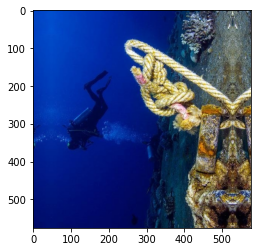

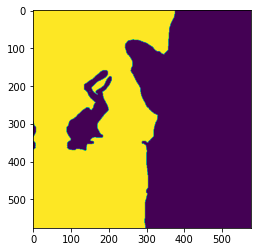

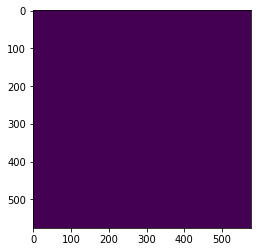

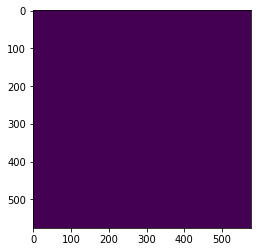

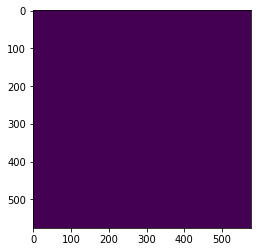

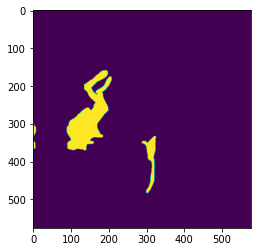

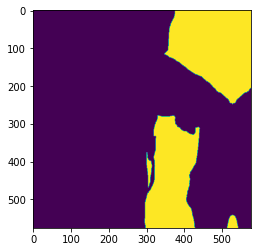

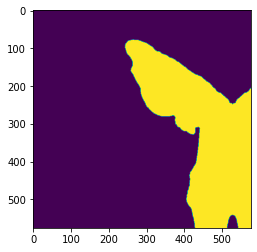

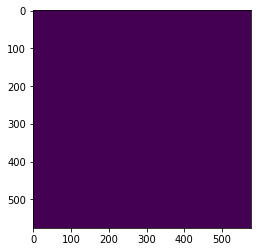

In [ ]:
# An example of image with their masks
for data, mask in train_loader:
    data1 = data[0].permute(2,1,0).long().numpy()
    plt.imshow(data1[:,:,[2,1,0]])
    plt.show()
    for i in range(8):
        plt.imshow((mask == i)[0].numpy() * 255)
        plt.show()
    break

## ***1st ARCHETECTURE***

In [ ]:
# the neural network U-Net  
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=8, init_features=32):
        super(UNet, self).__init__()

        
        features = init_features
        self.encoder1 = self._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = self._block(features * 8, features * 16, name="bottleneck")
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block(features * 8 * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 4 * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 2 * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)


    def _block(self, in_channels, features, name):

      return nn.Sequential(
          nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(features),
          nn.ReLU(inplace=True),
          nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(features),
          nn.ReLU(inplace=True),
      )


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Ajouter une couche de classification
        out = self.conv(dec1)
        out = F.interpolate(out, x.size()[2:], mode='bilinear', align_corners=True)

        return out


In [ ]:
#Training the neural network
# do not compile this code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs=100
model = UNet(in_channels=3, out_channels=8,init_features=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Loss_train,Loss_test = [],[]
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    running_loss = 0.0

    model.train()

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, masks.long())
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss_train = running_loss / len(train_loader.dataset)
    Loss_train.append(epoch_loss_train)
    print(f"Train loss: {epoch_loss_train:.4f}")

    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for images, masks in tqdm(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks.long())

            running_loss += loss.item() * images.size(0)

        epoch_loss_test = running_loss / len(test_loader.dataset)
        Loss_test.append(epoch_loss_test)
        print(f"Test loss: {epoch_loss_test:.4f}")


Epoch 1/100
--------------------


100%|██████████| 305/305 [00:49<00:00,  6.22it/s]


Train loss: 1.6168


100%|██████████| 77/77 [00:49<00:00,  1.57it/s]


Test loss: 1.5542
Epoch 2/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.28it/s]


Train loss: 1.5527


100%|██████████| 77/77 [00:04<00:00, 15.72it/s]


Test loss: 1.5371
Epoch 3/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.26it/s]


Train loss: 1.5220


100%|██████████| 77/77 [00:04<00:00, 15.68it/s]


Test loss: 1.5071
Epoch 4/100
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.49it/s]


Train loss: 1.5012


100%|██████████| 77/77 [00:05<00:00, 15.27it/s]


Test loss: 1.4787
Epoch 5/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4810


100%|██████████| 77/77 [00:04<00:00, 15.86it/s]


Test loss: 1.4584
Epoch 6/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4823


100%|██████████| 77/77 [00:05<00:00, 15.23it/s]


Test loss: 1.4642
Epoch 7/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.47it/s]


Train loss: 1.4738


100%|██████████| 77/77 [00:05<00:00, 15.33it/s]


Test loss: 1.4635
Epoch 8/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4723


100%|██████████| 77/77 [00:04<00:00, 15.70it/s]


Test loss: 1.4449
Epoch 9/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.47it/s]


Train loss: 1.4582


100%|██████████| 77/77 [00:04<00:00, 15.61it/s]


Test loss: 1.4380
Epoch 10/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.49it/s]


Train loss: 1.4590


100%|██████████| 77/77 [00:04<00:00, 15.42it/s]


Test loss: 1.4170
Epoch 11/100
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.49it/s]


Train loss: 1.4398


100%|██████████| 77/77 [00:05<00:00, 15.23it/s]


Test loss: 1.4157
Epoch 12/100
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.52it/s]


Train loss: 1.4369


100%|██████████| 77/77 [00:55<00:00,  1.38it/s]


Test loss: 1.4162
Epoch 13/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.47it/s]


Train loss: 1.4357


100%|██████████| 77/77 [00:04<00:00, 15.52it/s]


Test loss: 1.4096
Epoch 14/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.42it/s]


Train loss: 1.4289


100%|██████████| 77/77 [00:05<00:00, 14.60it/s]


Test loss: 1.3931
Epoch 15/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.44it/s]


Train loss: 1.4229


100%|██████████| 77/77 [00:05<00:00, 15.40it/s]


Test loss: 1.4244
Epoch 16/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4219


100%|██████████| 77/77 [00:04<00:00, 15.53it/s]


Test loss: 1.3895
Epoch 17/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.42it/s]


Train loss: 1.4143


100%|██████████| 77/77 [00:05<00:00, 15.27it/s]


Test loss: 1.3884
Epoch 18/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.39it/s]


Train loss: 1.4115


100%|██████████| 77/77 [00:05<00:00, 14.63it/s]


Test loss: 1.3889
Epoch 19/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.39it/s]


Train loss: 1.4117


100%|██████████| 77/77 [00:05<00:00, 15.16it/s]


Test loss: 1.3865
Epoch 20/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.4059


100%|██████████| 77/77 [00:05<00:00, 15.30it/s]


Test loss: 1.4012
Epoch 21/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.3991


100%|██████████| 77/77 [00:05<00:00, 15.36it/s]


Test loss: 1.3792
Epoch 22/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.3884


100%|██████████| 77/77 [00:05<00:00, 14.86it/s]


Test loss: 1.3775
Epoch 23/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.3881


100%|██████████| 77/77 [00:04<00:00, 15.45it/s]


Test loss: 1.3735
Epoch 24/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.40it/s]


Train loss: 1.3863


100%|██████████| 77/77 [00:05<00:00, 15.38it/s]


Test loss: 1.3904
Epoch 25/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.3787


100%|██████████| 77/77 [00:05<00:00, 14.66it/s]


Test loss: 1.3692
Epoch 26/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.3772


100%|██████████| 77/77 [00:05<00:00, 15.26it/s]


Test loss: 1.3779
Epoch 27/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.3691


100%|██████████| 77/77 [00:05<00:00, 15.32it/s]


Test loss: 1.3687
Epoch 28/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.40it/s]


Train loss: 1.3619


100%|██████████| 77/77 [00:05<00:00, 15.14it/s]


Test loss: 1.3687
Epoch 29/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 1.3595


100%|██████████| 77/77 [00:05<00:00, 14.98it/s]


Test loss: 1.3923
Epoch 30/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 1.3585


100%|██████████| 77/77 [00:05<00:00, 15.28it/s]


Test loss: 1.3844
Epoch 31/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 1.3570


100%|██████████| 77/77 [00:05<00:00, 14.65it/s]


Test loss: 1.3783
Epoch 32/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 1.3532


100%|██████████| 77/77 [00:05<00:00, 15.13it/s]


Test loss: 1.3515
Epoch 33/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 1.3538


100%|██████████| 77/77 [00:05<00:00, 14.78it/s]


Test loss: 1.3853
Epoch 34/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.35it/s]


Train loss: 1.3422


100%|██████████| 77/77 [00:05<00:00, 15.36it/s]


Test loss: 1.3609
Epoch 35/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.42it/s]


Train loss: 1.3428


100%|██████████| 77/77 [00:05<00:00, 14.94it/s]


Test loss: 1.3892
Epoch 36/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.3405


100%|██████████| 77/77 [00:05<00:00, 15.00it/s]


Test loss: 1.3523
Epoch 37/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.25it/s]


Train loss: 1.3372


100%|██████████| 77/77 [00:05<00:00, 14.82it/s]


Test loss: 1.3526
Epoch 38/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.28it/s]


Train loss: 1.3346


100%|██████████| 77/77 [00:05<00:00, 15.05it/s]


Test loss: 1.3590
Epoch 39/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.33it/s]


Train loss: 1.3337


100%|██████████| 77/77 [00:05<00:00, 15.17it/s]


Test loss: 1.3619
Epoch 40/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.43it/s]


Train loss: 1.3277


100%|██████████| 77/77 [00:04<00:00, 15.48it/s]


Test loss: 1.3477
Epoch 41/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.43it/s]


Train loss: 1.3229


100%|██████████| 77/77 [00:05<00:00, 14.94it/s]


Test loss: 1.3498
Epoch 42/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.40it/s]


Train loss: 1.3218


100%|██████████| 77/77 [00:05<00:00, 15.39it/s]


Test loss: 1.3356
Epoch 43/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.39it/s]


Train loss: 1.3283


100%|██████████| 77/77 [00:05<00:00, 15.39it/s]


Test loss: 1.3583
Epoch 44/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.3147


100%|██████████| 77/77 [00:05<00:00, 15.34it/s]


Test loss: 1.3534
Epoch 45/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 1.3161


100%|██████████| 77/77 [00:05<00:00, 14.84it/s]


Test loss: 1.3741
Epoch 46/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.33it/s]


Train loss: 1.3056


100%|██████████| 77/77 [00:05<00:00, 15.00it/s]


Test loss: 1.3393
Epoch 47/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.27it/s]


Train loss: 1.3096


100%|██████████| 77/77 [00:05<00:00, 14.99it/s]


Test loss: 1.3390
Epoch 48/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.39it/s]


Train loss: 1.3085


100%|██████████| 77/77 [00:05<00:00, 15.22it/s]


Test loss: 1.3573
Epoch 49/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.2994


100%|██████████| 77/77 [00:05<00:00, 15.35it/s]


Test loss: 1.3413
Epoch 50/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.35it/s]


Train loss: 1.3050


100%|██████████| 77/77 [00:05<00:00, 15.28it/s]


Test loss: 1.3392
Epoch 51/100
--------------------


100%|██████████| 305/305 [00:49<00:00,  6.18it/s]


Train loss: 1.2974


100%|██████████| 77/77 [00:05<00:00, 14.51it/s]


Test loss: 1.3278
Epoch 52/100
--------------------


100%|██████████| 305/305 [00:49<00:00,  6.22it/s]


Train loss: 1.2958


100%|██████████| 77/77 [00:05<00:00, 15.15it/s]


Test loss: 1.3279
Epoch 53/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.2937


100%|██████████| 77/77 [00:05<00:00, 15.14it/s]


Test loss: 1.3551
Epoch 54/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.40it/s]


Train loss: 1.2886


100%|██████████| 77/77 [00:05<00:00, 15.15it/s]


Test loss: 1.3261
Epoch 55/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.2876


100%|██████████| 77/77 [00:04<00:00, 15.48it/s]


Test loss: 1.3366
Epoch 56/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.41it/s]


Train loss: 1.2793


100%|██████████| 77/77 [00:05<00:00, 15.28it/s]


Test loss: 1.3424
Epoch 57/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.2733


100%|██████████| 77/77 [00:05<00:00, 14.50it/s]


Test loss: 1.3627
Epoch 58/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.43it/s]


Train loss: 1.2808


100%|██████████| 77/77 [00:05<00:00, 15.16it/s]


Test loss: 1.3318
Epoch 59/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.43it/s]


Train loss: 1.2783


100%|██████████| 77/77 [00:04<00:00, 15.45it/s]


Test loss: 1.3242
Epoch 60/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.38it/s]


Train loss: 1.2633


100%|██████████| 77/77 [00:05<00:00, 15.04it/s]


Test loss: 1.3426
Epoch 61/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.28it/s]


Train loss: 1.2636


100%|██████████| 77/77 [00:05<00:00, 14.70it/s]


Test loss: 1.3330
Epoch 62/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 1.2521


100%|██████████| 77/77 [00:05<00:00, 15.02it/s]


Test loss: 1.3212
Epoch 63/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.33it/s]


Train loss: 1.2602


100%|██████████| 77/77 [00:05<00:00, 14.90it/s]


Test loss: 1.3281
Epoch 64/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.45it/s]


Train loss: 1.2455


100%|██████████| 77/77 [00:05<00:00, 15.13it/s]


Test loss: 1.3286
Epoch 65/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.40it/s]


Train loss: 1.2393


100%|██████████| 77/77 [00:05<00:00, 15.30it/s]


Test loss: 1.3596
Epoch 66/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.38it/s]


Train loss: 1.2380


100%|██████████| 77/77 [00:05<00:00, 15.11it/s]


Test loss: 1.3306
Epoch 67/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.31it/s]


Train loss: 1.2346


100%|██████████| 77/77 [00:05<00:00, 14.79it/s]


Test loss: 1.3660
Epoch 68/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.28it/s]


Train loss: 1.2196


100%|██████████| 77/77 [00:05<00:00, 15.16it/s]


Test loss: 1.3641
Epoch 69/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.36it/s]


Train loss: 1.2113


100%|██████████| 77/77 [00:05<00:00, 15.26it/s]


Test loss: 1.3698
Epoch 70/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.33it/s]


Train loss: 1.2153


100%|██████████| 77/77 [00:05<00:00, 15.11it/s]


Test loss: 1.3460
Epoch 71/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.40it/s]


Train loss: 1.1909


100%|██████████| 77/77 [00:04<00:00, 15.42it/s]


Test loss: 1.4061
Epoch 72/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.36it/s]


Train loss: 1.1872


100%|██████████| 77/77 [00:05<00:00, 15.28it/s]


Test loss: 1.3776
Epoch 73/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.23it/s]


Train loss: 1.1832


100%|██████████| 77/77 [00:05<00:00, 14.76it/s]


Test loss: 1.3521
Epoch 74/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 1.1618


100%|██████████| 77/77 [00:05<00:00, 14.87it/s]


Test loss: 1.3662
Epoch 75/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.32it/s]


Train loss: 1.1639


100%|██████████| 77/77 [00:05<00:00, 14.83it/s]


Test loss: 1.5907
Epoch 76/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.33it/s]


Train loss: 1.1417


100%|██████████| 77/77 [00:05<00:00, 14.83it/s]


Test loss: 1.3890
Epoch 77/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.31it/s]


Train loss: 1.1265


100%|██████████| 77/77 [00:05<00:00, 14.60it/s]


Test loss: 1.4823
Epoch 78/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 1.1077


100%|██████████| 77/77 [00:04<00:00, 15.48it/s]


Test loss: 1.5072
Epoch 79/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 1.0980


100%|██████████| 77/77 [00:05<00:00, 14.83it/s]


Test loss: 1.6027
Epoch 80/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.25it/s]


Train loss: 1.0862


100%|██████████| 77/77 [00:05<00:00, 15.09it/s]


Test loss: 1.5197
Epoch 81/100
--------------------


100%|██████████| 305/305 [00:49<00:00,  6.21it/s]


Train loss: 1.0604


100%|██████████| 77/77 [00:05<00:00, 15.02it/s]


Test loss: 1.5188
Epoch 82/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.26it/s]


Train loss: 1.0371


100%|██████████| 77/77 [00:04<00:00, 15.41it/s]


Test loss: 1.4536
Epoch 83/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 1.0096


100%|██████████| 77/77 [00:05<00:00, 15.14it/s]


Test loss: 1.5250
Epoch 84/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.33it/s]


Train loss: 1.0013


100%|██████████| 77/77 [00:05<00:00, 14.95it/s]


Test loss: 1.5630
Epoch 85/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 0.9914


100%|██████████| 77/77 [00:05<00:00, 14.45it/s]


Test loss: 1.4883
Epoch 86/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.25it/s]


Train loss: 0.9716


100%|██████████| 77/77 [00:05<00:00, 14.93it/s]


Test loss: 1.6024
Epoch 87/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.27it/s]


Train loss: 0.9597


100%|██████████| 77/77 [00:05<00:00, 14.94it/s]


Test loss: 1.7821
Epoch 88/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.38it/s]


Train loss: 0.9161


100%|██████████| 77/77 [00:05<00:00, 15.17it/s]


Test loss: 1.6575
Epoch 89/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.38it/s]


Train loss: 0.9098


100%|██████████| 77/77 [00:05<00:00, 14.97it/s]


Test loss: 1.6313
Epoch 90/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.37it/s]


Train loss: 0.8793


100%|██████████| 77/77 [00:04<00:00, 15.64it/s]


Test loss: 1.5543
Epoch 91/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.43it/s]


Train loss: 0.8595


100%|██████████| 77/77 [00:05<00:00, 15.35it/s]


Test loss: 1.6709
Epoch 92/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.34it/s]


Train loss: 0.8154


100%|██████████| 77/77 [00:05<00:00, 15.01it/s]


Test loss: 1.6707
Epoch 93/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.38it/s]


Train loss: 0.8203


100%|██████████| 77/77 [00:05<00:00, 15.35it/s]


Test loss: 1.8700
Epoch 94/100
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.36it/s]


Train loss: 0.7891


100%|██████████| 77/77 [00:05<00:00, 15.06it/s]


Test loss: 1.6948
Epoch 95/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 0.7851


100%|██████████| 77/77 [00:05<00:00, 14.25it/s]


Test loss: 2.0820
Epoch 96/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.29it/s]


Train loss: 0.7760


100%|██████████| 77/77 [00:05<00:00, 15.29it/s]


Test loss: 1.9068
Epoch 97/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.31it/s]


Train loss: 0.7412


100%|██████████| 77/77 [00:05<00:00, 14.68it/s]


Test loss: 1.6258
Epoch 98/100
--------------------


100%|██████████| 305/305 [00:49<00:00,  6.20it/s]


Train loss: 0.7207


100%|██████████| 77/77 [00:05<00:00, 14.44it/s]


Test loss: 2.0576
Epoch 99/100
--------------------


100%|██████████| 305/305 [00:48<00:00,  6.23it/s]


Train loss: 0.7024


100%|██████████| 77/77 [00:05<00:00, 15.29it/s]


Test loss: 1.9567
Epoch 100/100
--------------------


100%|██████████| 305/305 [00:49<00:00,  6.17it/s]


Train loss: 0.7220


100%|██████████| 77/77 [00:05<00:00, 14.03it/s]

Test loss: 2.3536


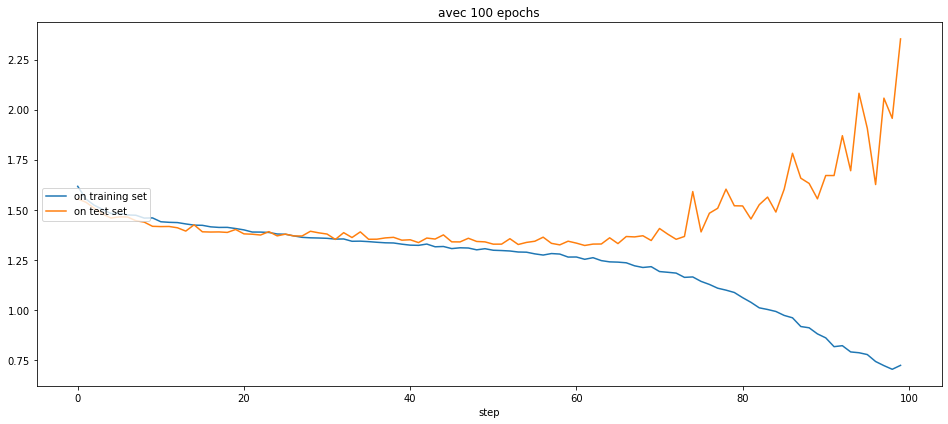

In [ ]:
#Loss metrcis for Test and Training set
plt.figure(figsize=(26,6))
plt.subplot(1, 2, 1)
plt.plot(Loss_train,
            label="on training set")

plt.plot(Loss_test,
            label = "on test set")
plt.title('avec 100 epochs')        
plt.xlabel('step')
plt.legend(loc='center left')
plt.tight_layout()
plt.show();


In [ ]:
# On va refaire l'entrainement et s'arreter dans l'epochs ... car avec 100 epochs 
#on tombe sur l'overfitting et on enregistre le modele

# Avec 40 epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
num_epochs=40
model = UNet(in_channels=3, out_channels=8,init_features=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Loss_train,Loss_test = [],[]
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    running_loss = 0.0

    model.train()

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, masks.long())
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss_train = running_loss / len(train_loader.dataset)
    Loss_train.append(epoch_loss_train)
    print(f"Train loss: {epoch_loss_train:.4f}")

    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for images, masks in tqdm(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks.long())

            running_loss += loss.item() * images.size(0)

        epoch_loss_test = running_loss / len(test_loader.dataset)
        Loss_test.append(epoch_loss_test)
        print(f"Test loss: {epoch_loss_test:.4f}")


Epoch 1/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.52it/s]


Train loss: 1.5968


100%|██████████| 77/77 [00:05<00:00, 15.10it/s]


Test loss: 1.5678
Epoch 2/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.51it/s]


Train loss: 1.5685


100%|██████████| 77/77 [00:04<00:00, 15.62it/s]


Test loss: 1.5537
Epoch 3/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.49it/s]


Train loss: 1.5398


100%|██████████| 77/77 [00:04<00:00, 15.65it/s]


Test loss: 1.5153
Epoch 4/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.5238


100%|██████████| 77/77 [00:04<00:00, 15.51it/s]


Test loss: 1.5122
Epoch 5/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.49it/s]


Train loss: 1.5152


100%|██████████| 77/77 [00:05<00:00, 15.34it/s]


Test loss: 1.5007
Epoch 6/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.50it/s]


Train loss: 1.5137


100%|██████████| 77/77 [00:04<00:00, 15.84it/s]


Test loss: 1.4809
Epoch 7/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.51it/s]


Train loss: 1.4980


100%|██████████| 77/77 [00:04<00:00, 15.62it/s]


Test loss: 1.4655
Epoch 8/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4864


100%|██████████| 77/77 [00:05<00:00, 15.25it/s]


Test loss: 1.5020
Epoch 9/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.51it/s]


Train loss: 1.4836


100%|██████████| 77/77 [00:05<00:00, 14.81it/s]


Test loss: 1.4504
Epoch 10/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.46it/s]


Train loss: 1.4659


100%|██████████| 77/77 [00:05<00:00, 15.16it/s]


Test loss: 1.4482
Epoch 11/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.47it/s]


Train loss: 1.4613


100%|██████████| 77/77 [00:05<00:00, 15.34it/s]


Test loss: 1.4280
Epoch 12/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4565


100%|██████████| 77/77 [00:04<00:00, 15.63it/s]


Test loss: 1.4642
Epoch 13/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.51it/s]


Train loss: 1.4505


100%|██████████| 77/77 [00:04<00:00, 15.46it/s]


Test loss: 1.5013
Epoch 14/40
--------------------


100%|██████████| 305/305 [01:20<00:00,  3.80it/s]


Train loss: 1.4531


100%|██████████| 77/77 [00:05<00:00, 15.21it/s]


Test loss: 1.4172
Epoch 15/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.49it/s]


Train loss: 1.4395


100%|██████████| 77/77 [00:05<00:00, 15.32it/s]


Test loss: 1.4289
Epoch 16/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4275


100%|██████████| 77/77 [00:05<00:00, 15.00it/s]


Test loss: 1.4242
Epoch 17/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.4298


100%|██████████| 77/77 [00:04<00:00, 15.46it/s]


Test loss: 1.4161
Epoch 18/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.45it/s]


Train loss: 1.4196


100%|██████████| 77/77 [00:05<00:00, 15.08it/s]


Test loss: 1.4289
Epoch 19/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.52it/s]


Train loss: 1.4084


100%|██████████| 77/77 [00:04<00:00, 15.43it/s]


Test loss: 1.4126
Epoch 20/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.46it/s]


Train loss: 1.4073


100%|██████████| 77/77 [00:04<00:00, 15.87it/s]


Test loss: 1.4203
Epoch 21/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.48it/s]


Train loss: 1.3997


100%|██████████| 77/77 [00:05<00:00, 15.16it/s]


Test loss: 1.4035
Epoch 22/40
--------------------


100%|██████████| 305/305 [00:47<00:00,  6.47it/s]


Train loss: 1.3962


100%|██████████| 77/77 [00:04<00:00, 15.81it/s]


Test loss: 1.3953
Epoch 23/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.51it/s]


Train loss: 1.3905


100%|██████████| 77/77 [00:05<00:00, 14.84it/s]


Test loss: 1.4715
Epoch 24/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.57it/s]


Train loss: 1.3909


100%|██████████| 77/77 [00:05<00:00, 15.24it/s]


Test loss: 1.3921
Epoch 25/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.59it/s]


Train loss: 1.3839


100%|██████████| 77/77 [00:04<00:00, 15.77it/s]


Test loss: 1.4021
Epoch 26/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.57it/s]


Train loss: 1.3843


100%|██████████| 77/77 [00:04<00:00, 15.88it/s]


Test loss: 1.3819
Epoch 27/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.55it/s]


Train loss: 1.3847


100%|██████████| 77/77 [00:04<00:00, 15.43it/s]


Test loss: 1.4021
Epoch 28/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.59it/s]


Train loss: 1.3757


100%|██████████| 77/77 [00:05<00:00, 15.05it/s]


Test loss: 1.3928
Epoch 29/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.58it/s]


Train loss: 1.3736


100%|██████████| 77/77 [00:05<00:00, 14.81it/s]


Test loss: 1.3952
Epoch 30/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.62it/s]


Train loss: 1.3704


100%|██████████| 77/77 [00:05<00:00, 15.33it/s]


Test loss: 1.3966
Epoch 31/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.57it/s]


Train loss: 1.3777


100%|██████████| 77/77 [00:04<00:00, 15.77it/s]


Test loss: 1.4234
Epoch 32/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.58it/s]


Train loss: 1.3752


100%|██████████| 77/77 [00:04<00:00, 15.50it/s]


Test loss: 1.4017
Epoch 33/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.56it/s]


Train loss: 1.3650


100%|██████████| 77/77 [00:04<00:00, 15.62it/s]


Test loss: 1.3662
Epoch 34/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.56it/s]


Train loss: 1.3608


100%|██████████| 77/77 [00:05<00:00, 15.11it/s]


Test loss: 1.3976
Epoch 35/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.57it/s]


Train loss: 1.3568


100%|██████████| 77/77 [00:05<00:00, 15.37it/s]


Test loss: 1.3943
Epoch 36/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.60it/s]


Train loss: 1.3644


100%|██████████| 77/77 [00:04<00:00, 15.46it/s]


Test loss: 1.3856
Epoch 37/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.60it/s]


Train loss: 1.3606


100%|██████████| 77/77 [00:04<00:00, 15.86it/s]


Test loss: 1.3909
Epoch 38/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.59it/s]


Train loss: 1.3579


100%|██████████| 77/77 [00:04<00:00, 15.42it/s]


Test loss: 1.3807
Epoch 39/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.57it/s]


Train loss: 1.3507


100%|██████████| 77/77 [00:04<00:00, 15.69it/s]


Test loss: 1.3921
Epoch 40/40
--------------------


100%|██████████| 305/305 [00:46<00:00,  6.55it/s]


Train loss: 1.3500


100%|██████████| 77/77 [00:04<00:00, 16.01it/s]

Test loss: 1.3738


In [ ]:
# Saving of the model
state_dict = model.state_dict()
# Save the state dictionary to a file
torch.save(state_dict, 'segementation_model_iogs.pt')

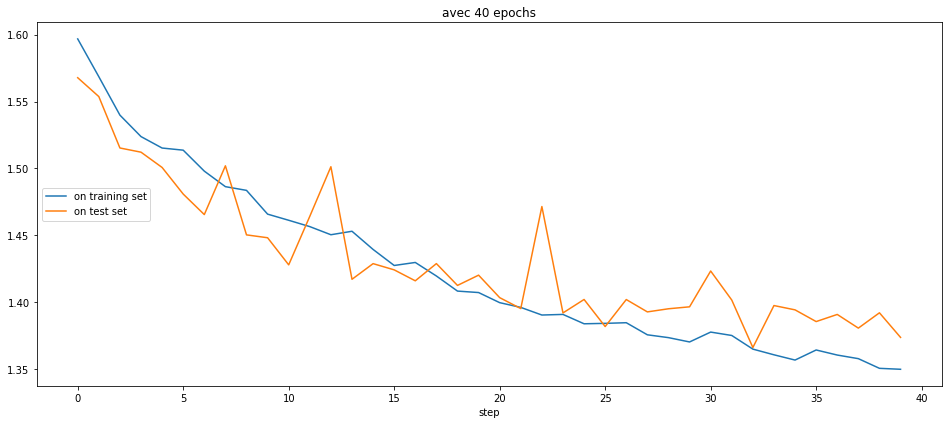

In [ ]:
# nous avons augumenter le learning rate dans le training pour esperer une convergence plus rapide puisque on a pris 40 epochs
#Loss metrcis for Test and Training set
plt.figure(figsize=(26,6))
plt.subplot(1, 2, 1)
plt.plot(Loss_train,
            label="on training set")

plt.plot(Loss_test,
            label = "on test set")
plt.title('avec 40 epochs')        
plt.xlabel('step')
plt.legend(loc='center left')
plt.tight_layout()
plt.show();


In [ ]:
# Load of the model
modell = UNet()
# Load the saved state dictionary
state_dict = torch.load('/content/segementation_model_iogs.pt')
# Load the state dictionary into the model
modell.load_state_dict(state_dict)

<All keys matched successfully>

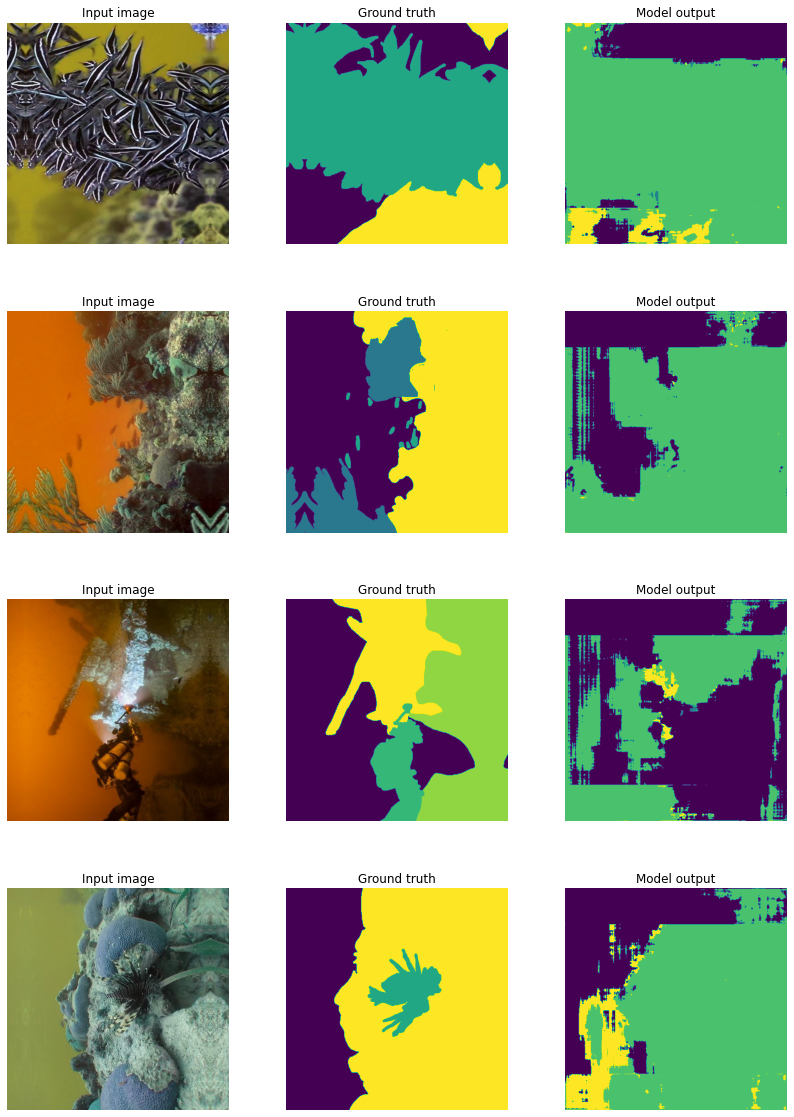

In [ ]:
# Dataset de Test
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Afficher les images ground truth

images, masks = next(iter(test_loader))

# Faire passer les images dans le modèle pour obtenir les sorties

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modell = modell.to(device)
modell.eval()

with torch.no_grad():
    outputs = modell(images.to(device))
    outputs = ((outputs).float()) * 255

pred_masks = torch.argmax(outputs, dim=1, keepdim=True)

# Préparer les images à afficher
grid_images = make_grid(images, nrow=1, normalize=True)


# Afficher les images
fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
for i, (image, mask, pred_mask) in enumerate(zip(images, masks, pred_masks)):

    grid_image = make_grid(image, nrow=1, normalize=True)
    axs[i][0].imshow(grid_image.cpu().permute(2, 1, 0))
    axs[i][0].axis('off')
    axs[i][0].set_title("Input image")

    axs[i][1].imshow(mask.squeeze().cpu())
    axs[i][1].axis('off')
    axs[i][1].set_title("Ground truth")

    axs[i][2].imshow(pred_mask.squeeze().cpu().permute(1, 0))
    axs[i][2].axis('off')
    axs[i][2].set_title("Model output")

plt.subplots_adjust(wspace=0, hspace=0.3)


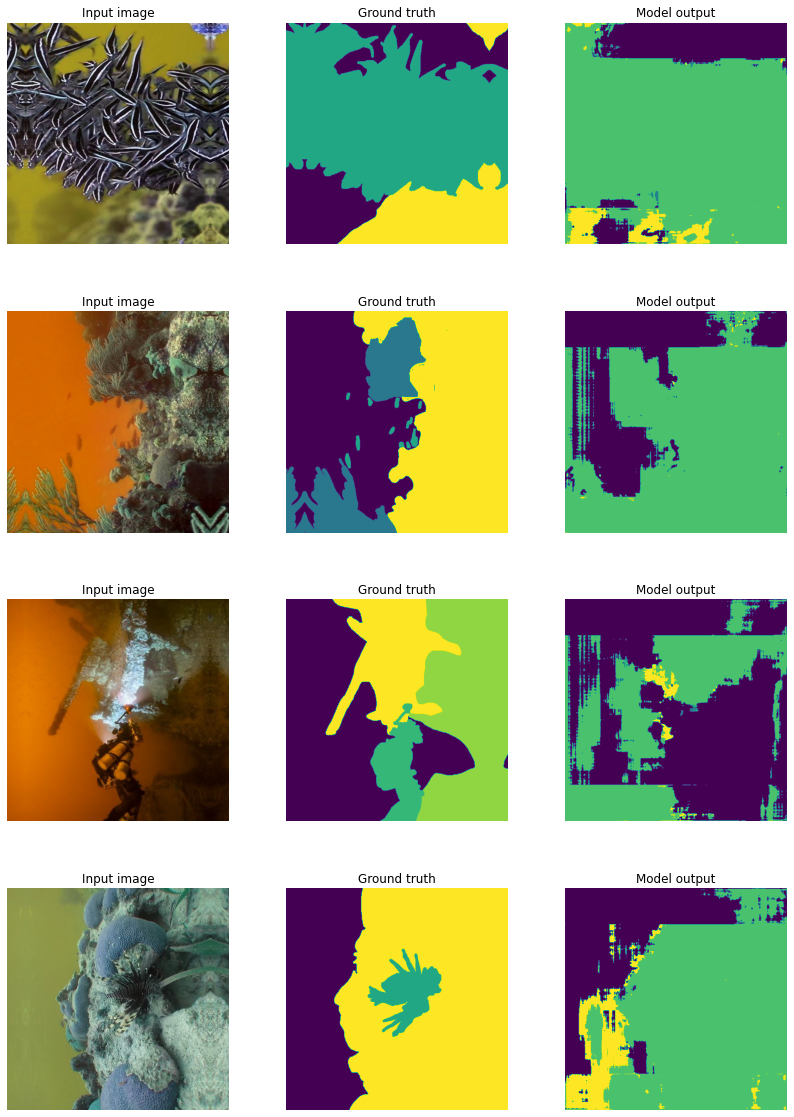

In [ ]:
# Dataset de Test
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Afficher les images ground truth

images, masks = next(iter(test_loader))

# Faire passer les images dans le modèle pour obtenir les sorties

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(images.to(device))
    outputs = ((outputs).float()) * 255

pred_masks = torch.argmax(outputs, dim=1, keepdim=True)

# Préparer les images à afficher
grid_images = make_grid(images, nrow=1, normalize=True)


# Afficher les images
fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
for i, (image, mask, pred_mask) in enumerate(zip(images, masks, pred_masks)):

    grid_image = make_grid(image, nrow=1, normalize=True)
    axs[i][0].imshow(grid_image.cpu().permute(2, 1, 0))
    axs[i][0].axis('off')
    axs[i][0].set_title("Input image")

    axs[i][1].imshow(mask.squeeze().cpu())
    axs[i][1].axis('off')
    axs[i][1].set_title("Ground truth")

    axs[i][2].imshow(pred_mask.squeeze().cpu().permute(1, 0))
    axs[i][2].axis('off')
    axs[i][2].set_title("Model output")

plt.subplots_adjust(wspace=0, hspace=0.3)


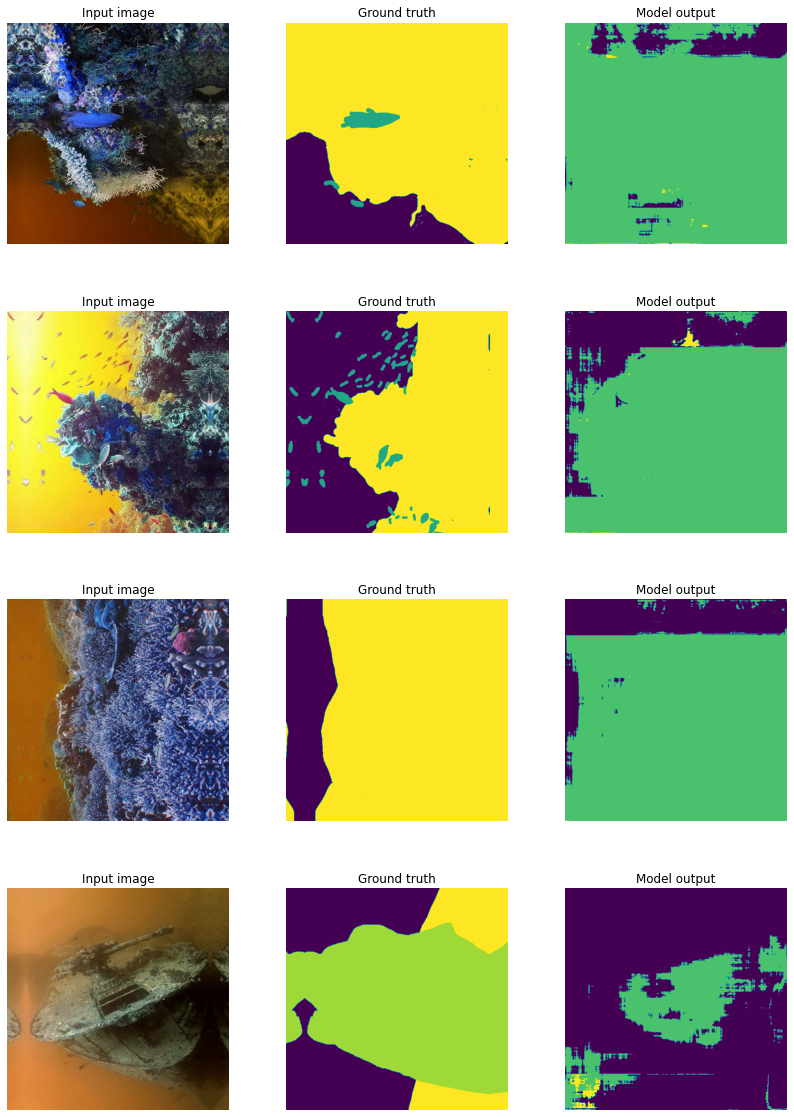

In [ ]:
# Dataset de Training

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Afficher les images ground truth

images, masks = next(iter(train_loader))

# Faire passer les images dans le modèle pour obtenir les sorties

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modell = modell.to(device)
modell.eval()

with torch.no_grad():
    outputs = modell(images.to(device))
    outputs = ((outputs).float()) * 255

pred_masks = torch.argmax(outputs, dim=1, keepdim=True)

# Préparer les images à afficher
grid_images = make_grid(images, nrow=1, normalize=True)


# Afficher les images
fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
for i, (image, mask, pred_mask) in enumerate(zip(images, masks, pred_masks)):

    grid_image = make_grid(image, nrow=1, normalize=True)
    axs[i][0].imshow(grid_image.cpu().permute(2, 1, 0))
    axs[i][0].axis('off')
    axs[i][0].set_title("Input image")

    axs[i][1].imshow(mask.squeeze().cpu())
    axs[i][1].axis('off')
    axs[i][1].set_title("Ground truth")

    axs[i][2].imshow(pred_mask.squeeze().cpu().permute(1, 0))
    axs[i][2].axis('off')
    axs[i][2].set_title("Model output")

plt.subplots_adjust(wspace=0, hspace=0.3)


## **Note:** 

The dataset size used for training the model is insufficient for effectively solving the multiclass segmentation problem at hand. With only 303 images, it is challenging to achieve the desired level of accuracy, especially when compared to the much larger datasets on which pretrained ML models are trained.

Despite this limitation, we are still able to identify the presence of different zones or classes, even if the masks do not match the ground truth as closely as we would like.

To obtain more accurate results, we require a more extensive training dataset. The masks in the current dataset are highly precise, with objects segmented almost pixel by pixel. Therefore, we need a much larger dataset to improve our model's performance.

We opted to use Colab Pro because training with a GPU takes an extensive amount of time. Furthermore, the computing resources provided by the normal version of Google Colab are quickly exhausted, and we require a more robust infrastructure to handle the workload.